In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import os

In [76]:
nltk.download('stopwords')
nltk.download('punkt')
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\william.block\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\william.block\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [77]:
tweet= pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [78]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


Text(0,0.5,'samples')

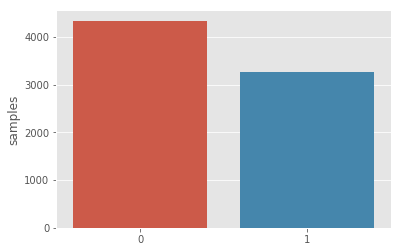

In [79]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

# Exploratory Data Analysis of tweets
First,we will do very basic analysis,that is character level,word level and sentence level analysis.

## Number of characters in tweets

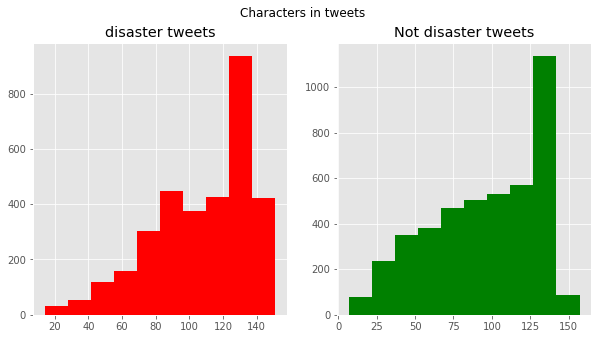

In [80]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distribution of both seems to be almost same.120 t0 140 characters in a tweet are the most common among both.

## Number of words in a tweet

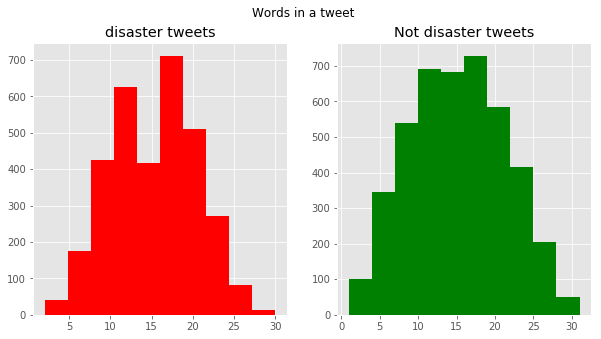

In [81]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

## Average word length in a tweet

Text(0.5,0.98,'Average word length in each tweet')

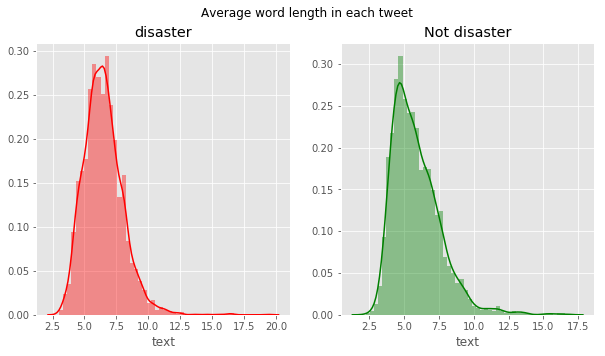

In [82]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [83]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

## Common stopwords in tweets

First we will analyze tweets with class 0.

In [84]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

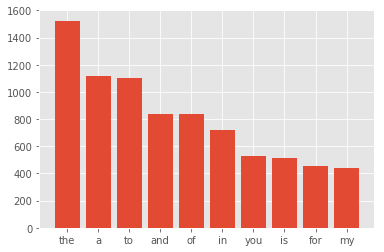

In [85]:
x,y=zip(*top)
plt.bar(x,y)

Now,we will analyze tweets with class 1.

<BarContainer object of 10 artists>

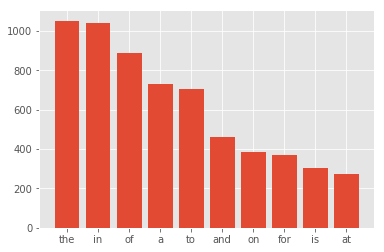

In [86]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

## Analyzing punctuations.
First let's check tweets indicating real disaster.

<BarContainer object of 18 artists>

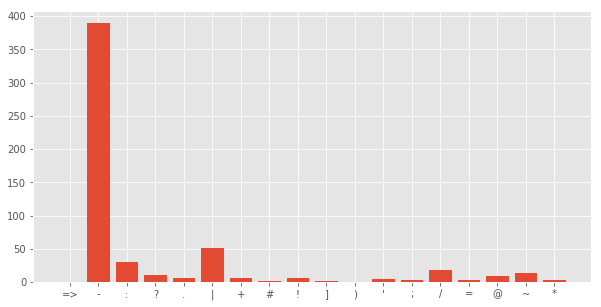

In [87]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

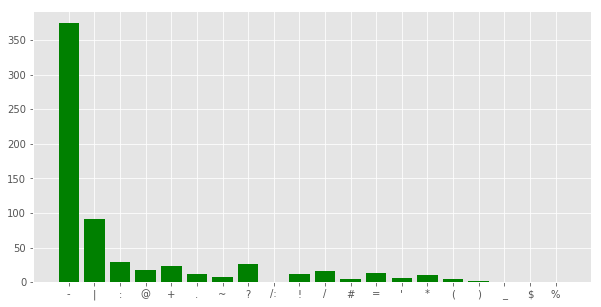

In [88]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

### Common words ?

In [89]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

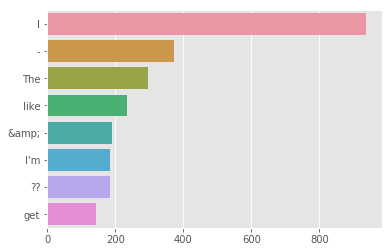

In [90]:
sns.barplot(x=y,y=x)

Lot of cleaning needed !

## Ngram analysis
we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [91]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

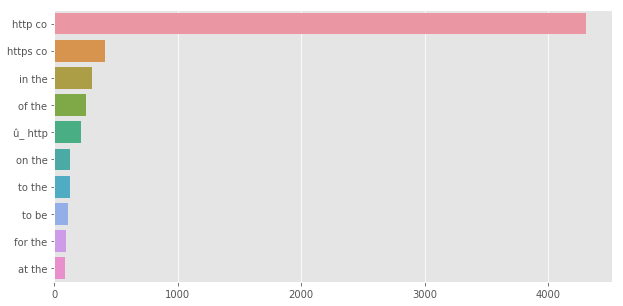

In [92]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

We will need lot of cleaning here..

## Data Cleaning
As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [93]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [94]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [95]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [96]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [97]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [98]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [99]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [100]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [101]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [102]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [103]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

## Spelling Correction
Even if I'm not good at spelling I can correct it with python :) I will use pyspellcheker to do tha

In [104]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me please'

In [105]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x))

## GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.

In [106]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [107]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 6719.33it/s]


In [109]:
embedding_dict={}
with open('./glove.6B/glove.6B.100d.txt','r', encoding="utf8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [110]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [111]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [112]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 484349.19it/s]


In [117]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [118]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [119]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [120]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [121]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 59s - loss: 0.6915 - acc: 0.5682 - val_loss: 0.6899 - val_acc: 0.5665
Epoch 2/15
 - 54s - loss: 0.6867 - acc: 0.5710 - val_loss: 0.6817 - val_acc: 0.5665
Epoch 3/15
 - 54s - loss: 0.6410 - acc: 0.6178 - val_loss: 0.5624 - val_acc: 0.7653
Epoch 4/15
 - 57s - loss: 0.5884 - acc: 0.7187 - val_loss: 0.5256 - val_acc: 0.7793
Epoch 5/15
 - 59s - loss: 0.5706 - acc: 0.7246 - val_loss: 0.5141 - val_acc: 0.7767
Epoch 6/15
 - 58s - loss: 0.5622 - acc: 0.7368 - val_loss: 0.5051 - val_acc: 0.7758
Epoch 7/15
 - 58s - loss: 0.5611 - acc: 0.7441 - val_loss: 0.4980 - val_acc: 0.7785
Epoch 8/15
 - 54s - loss: 0.5519 - acc: 0.7444 - val_loss: 0.4932 - val_acc: 0.7820
Epoch 9/15
 - 54s - loss: 0.5500 - acc: 0.7480 - val_loss: 0.4890 - val_acc: 0.7837
Epoch 10/15
 - 54s - loss: 0.5493 - acc: 0.7531 - val_loss: 0.4860 - val_acc: 0.7855
Epoch 11/15
 - 55s - loss: 0.5463 - acc: 0.7527 - val_loss: 0.4822 - val_acc: 0.7890
Epoch 12/15
 - 54s - loss: